In [83]:
"""Something is wrong here. This experiment should match the results from the GECCO paper for leader-follower structural credit assignment results
D-Indirect-Traj is wayyy underperforming. G almost seems like the ceiling that D-Indirect cannot break... which is not how it should be
"""
import os
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from influence.plotting import generate_learning_curve_plot, LinePlotArgs, PlotArgs, generate_joint_trajectory_plot

In [17]:
# Load in D-Indirect-Traj trial 9, final joint trajectory after 500 generations
trial_9_dir = Path(os.path.expanduser('~/influence-shaping/results/01_05_2025/jabiru/D-Indirect-Traj/trial_9/'))
traj_dir = trial_9_dir / 'gen_500'/'eval_team_0_joint_traj.csv'
fit_dir = trial_9_dir / 'fitness.csv'
traj_df = pd.read_csv(traj_dir)
fit_df = pd.read_csv(fit_dir)

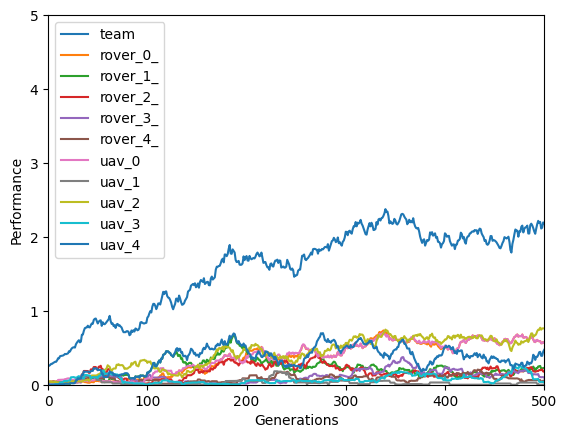

In [4]:
fit_fig = generate_learning_curve_plot(
    fitness_dir=fit_dir,
    individual_agents=True,
    line_plot_args=LinePlotArgs(
        window_size=20,
        downsample=1
    ),
    plot_args=PlotArgs(ylim=[0,5])
)

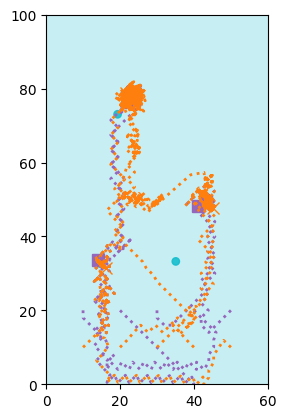

In [11]:
traj_fig = generate_joint_trajectory_plot(
    joint_traj_dir=traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs()
)

In [29]:
print(fit_df['team_fitness_aggregated'].iloc[-1])

2.555290935016172


In [38]:
# Plot the final positions of everything
traj_df['rover_0_x'].iloc[-1]

rover_xs = [traj_df['rover_'+str(i)+'_x'].iloc[-1] for i in range(5)]
rover_ys = [traj_df['rover_'+str(i)+'_y'].iloc[-1] for i in range(5)]
uav_xs = [traj_df['uav_'+str(i)+'_x'].iloc[-1] for i in range(5)]
uav_ys = [traj_df['uav_'+str(i)+'_y'].iloc[-1] for i in range(5)]
poi_xs = [traj_df['hidden_poi_'+str(i)+'_x'].iloc[-1] for i in range(5)]
poi_ys = [traj_df['hidden_poi_'+str(i)+'_y'].iloc[-1] for i in range(5)]

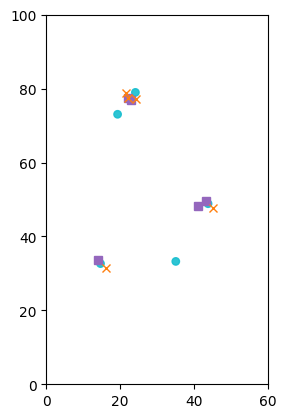

In [45]:
fig, ax = plt.subplots(1,1)
for x,y in zip(rover_xs, rover_ys):
    ax.plot(x,y,'s',color='tab:purple')
for x,y in zip(uav_xs, uav_ys):
    ax.plot(x,y,'x',color='tab:orange')
for x,y in zip(poi_xs, poi_ys):
    center_circle = plt.Circle(
        xy = (x, y),
        radius = 1.0,
        color='tab:cyan',
        fill=True,
        alpha=0.9
        )
    ax.add_patch(center_circle)

ax.set_ylim([0,100])
ax.set_xlim([0,60])
ax.set_aspect('equal')

In [48]:
# Let's break down G by each poi
def compute_min_dist_for_poi(poi_x, poi_y, rover_xs, rover_ys):
    min_dist = None
    for rover_x, rover_y in zip(rover_xs, rover_ys):
        dist = np.linalg.norm(
            np.array([rover_x, rover_y]) - np.array([poi_x, poi_y])
        )
        if min_dist is None or dist < min_dist:
            min_dist = dist
    return min_dist

def compute_G_for_poi(min_dist):
    return 1/max(1.0, min_dist)

total_reward = 0
for poi_x, poi_y in zip(poi_xs, poi_ys):
    print(f'poi x: {poi_x} | poi_y: {poi_y}')
    min_dist = compute_min_dist_for_poi(poi_x, poi_y, rover_xs, rover_ys)
    print(f'min_dist: {min_dist}')
    reward = compute_G_for_poi(min_dist)
    print(f'reward: {reward}')
    total_reward += reward
print(f'total reward: {total_reward}')

def compute_G(poi_xs, poi_ys, rover_xs, rover_ys):
    total_reward = 0
    for poi_x, poi_y in zip(poi_xs, poi_ys):
        min_dist = compute_min_dist_for_poi(poi_x, poi_y, rover_xs, rover_ys)
        reward = compute_G_for_poi(min_dist)
        total_reward += reward
    return total_reward
print(f'double check total reward: {compute_G(poi_xs, poi_ys, rover_xs, rover_ys)}')
# Looks like G is computed correctly

poi x: 43.82260875897609 | poi_y: 48.855650492528326
min_dist: 0.9819438937150303
reward: 1.0
poi x: 14.716154300935392 | poi_y: 32.650665429258275
min_dist: 1.135084543673046
reward: 0.8809916455774098
poi x: 19.3438998927915 | poi_y: 73.04902428848098
min_dist: 5.142951436886421
reward: 0.19444087938061633
poi x: 24.16269740817124 | poi_y: 78.9742230913971
min_dist: 2.3919897013917013
reward: 0.41806200060902543
poi x: 35.090102675981925 | poi_y: 33.24306430318973
min_dist: 16.182169949911906
reward: 0.06179640944911989
total reward: 2.555290935016171
double check total reward: 2.555290935016171


In [49]:
# Nothing looks wrong about how G is being computed... Is D-Indirect being computed wrong?
# Or maybe even more simply - is D being computed wrong and then D-Indirect running on top of that also becomes wrong?

# I'll start by checking D for each rover
def compute_counterfactual_G(poi_xs, poi_ys, rover_xs, rover_ys, rover_id_to_remove):
    filtered_rover_xs = []
    filtered_rover_ys = []
    for id_, (rover_x, rover_y) in enumerate(zip(rover_xs, rover_ys)):
        if id_ != rover_id_to_remove:
            filtered_rover_xs.append(rover_x)
            filtered_rover_ys.append(rover_y)
    return compute_G(poi_xs, poi_ys, rover_xs=filtered_rover_xs, rover_ys=filtered_rover_ys)

def compute_D(G, poi_xs, poi_ys, rover_xs, rover_ys, rover_id_to_remove):
    return G - compute_counterfactual_G(poi_xs, poi_ys, rover_xs, rover_ys, rover_id_to_remove)

G = compute_G(poi_xs, poi_ys, rover_xs, rover_ys)
for rover_id in range(5):
    print(f'(x,y) | ({rover_xs[rover_id]},{rover_ys[rover_id]})')
    D = compute_D(
        G, poi_xs, poi_ys, rover_xs, rover_ys, rover_id_to_remove=rover_id
    )
    print(f'D: {D}')
# Looks like D for the rovers is computed correctly

(x,y) | (14.07868382777968,33.58983970336297)
D: 0.848446073613895
(x,y) | (22.86930877610193,76.79354584505506)
D: 0.008068499529695572
(x,y) | (43.16584963755466,49.585637661479936)
D: 0.6289925101050347
(x,y) | (22.22000662784824,77.57867041821993)
D: 0.02364551452483621
(x,y) | (41.20163399888307,48.22678243912082)
D: 0.0069388436139288245


In [54]:
# Let's see if we can compute D-Indirect-Traj here

# Start with the influence counters... Try to make it as close as possible to the 
# original implementation of D-Indirect

# Influence is (in a way) follower-centric. So start there
def compute_influence_on_one_rover(
        single_rover_xs, single_rover_ys, all_uav_xs, all_uav_ys
    ):
        '''single_rover_xs: x for this rover at each timestep
        all_uav_xs: list of uavs. Each nested list is a list of x for uav _ at each timestep
        '''
        num_uavs = len(all_uav_xs)
        leader_influence = [0 for _ in range(num_uavs)]

        for t, (rover_x, rover_y) in enumerate(zip(single_rover_xs, single_rover_ys)):
            for uav_id in range(num_uavs):
                if np.linalg.norm(
                    np.array([all_uav_xs[uav_id][t], all_uav_ys[uav_id][t]]) - \
                    np.array([rover_x, rover_y])
                ) <= 5:
                    leader_influence[uav_id]+=1
        return leader_influence

all_uav_xs = [traj_df['uav_'+str(i)+'_x'] for i in range(5)]
all_uav_ys = [traj_df['uav_'+str(i)+'_y'] for i in range(5)]

In [55]:
# Let's check the influence for rover 0
leader_influence_on_rover_0 = compute_influence_on_one_rover(
    single_rover_xs=traj_df['rover_0_x'],
    single_rover_ys=traj_df['rover_0_y'],
    all_uav_xs=all_uav_xs,
    all_uav_ys=all_uav_ys
)
print('leader_influence for rover 0:', leader_influence_on_rover_0)

leader_influence for rover 0: [199, 0, 0, 0, 7]


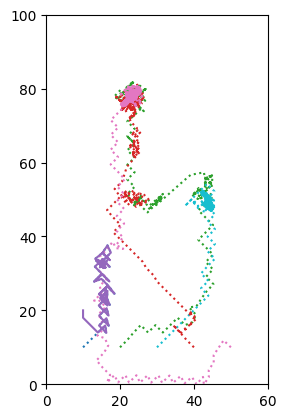

In [67]:
# Let's plot just the trajectories of rover 0 and the uavs. 
# Maybe we can see clearly whether or not this influence list (array) makes sense
fig, ax = plt.subplots(1,1)
colors = ['tab:blue', 'tab:green', 'tab:cyan', 'tab:red', 'tab:pink']
for i in range(5):
    ax.plot(
        traj_df['uav_'+str(i)+'_x'],
        traj_df['uav_'+str(i)+'_y'],
        ':',
        color=colors[i]
    )

ax.plot(traj_df['rover_0_x'], traj_df['rover_0_y'],color='tab:purple')
ax.set_ylim([0,100])
ax.set_xlim([0,60])
ax.set_aspect('equal')
# Looks right to me. This rover was influenced predominantly by 
# uav 0, the blue one, and a little by uav 4, the pink one

In [68]:
# Let's check the influence for rover 1
leader_influence_on_rover_1 = compute_influence_on_one_rover(
    single_rover_xs=traj_df['rover_1_x'],
    single_rover_ys=traj_df['rover_1_y'],
    all_uav_xs=all_uav_xs,
    all_uav_ys=all_uav_ys
)
print('leader_influence for rover 1:', leader_influence_on_rover_1)
# Rover 1 was influenced a lot more

leader_influence for rover 1: [4, 90, 0, 106, 192]


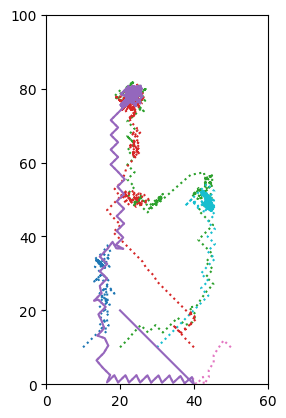

In [75]:
# Let's plot just the trajectories of rover 1 and the uavs. 
# Maybe we can see clearly whether or not this influence list (array) makes sense
fig, ax = plt.subplots(1,1)
colors = ['tab:blue', 'tab:green', 'tab:cyan', 'tab:red', 'tab:pink']
for i in range(5):
    ax.plot(
        traj_df['uav_'+str(i)+'_x'],
        traj_df['uav_'+str(i)+'_y'],
        ':',
        color=colors[i]
    )

ax.plot(traj_df['rover_1_x'], traj_df['rover_1_y'],color='tab:purple')
ax.set_ylim([0,100])
ax.set_xlim([0,60])
ax.set_aspect('equal')


In [76]:
# This looks fine to me. Hard to really tell much from this other than:
# Influence counting looks right. Time to go another step and compute
# D-Indirect-Traj as close as possible according to 
# the original implementation of D-Indirect and compare that to what
# is recorded for this joint trajectory

In [77]:
# Let's compute influence for everyone
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

all_leader_influence = [
        compute_influence_on_one_rover(
        single_rover_xs=traj_df['rover_'+str(i)+'_x'],
        single_rover_ys=traj_df['rover_'+str(i)+'_y'],
        all_uav_xs=all_uav_xs,
        all_uav_ys=all_uav_ys
    )
    for i in range(5)
]
all_assigned_followers = [[] for _ in range(5)]
for rover_id in range(5):
    all_assigned_followers[
        argmax(all_leader_influence[rover_id])
    ].append(rover_id)
print(all_assigned_followers)

[[0], [], [2, 4], [], [1, 3]]


In [79]:
# Now let's define a function for computing counterfactual G, but we remove multiple rovers
def compute_counterfactual_G_multiremoval(
        poi_xs, poi_ys, rover_xs, rover_ys, rover_ids_to_remove
    ):
    filtered_rover_xs = []
    filtered_rover_ys = []
    for id_, (rover_x, rover_y) in enumerate(zip(rover_xs, rover_ys)):
        if id_ not in rover_ids_to_remove:
            filtered_rover_xs.append(rover_x)
            filtered_rover_ys.append(rover_y)
    return compute_G(poi_xs, poi_ys, rover_xs=filtered_rover_xs, rover_ys=filtered_rover_ys)

def compute_D_Indirect(
        G, poi_xs, poi_ys, rover_xs, rover_ys, rover_ids_to_remove
    ):
    return G - compute_counterfactual_G_multiremoval(
        poi_xs, poi_ys, rover_xs, rover_ys, rover_ids_to_remove
    )


In [81]:
for rover_ids_to_remove in all_assigned_followers:
    D_Indirect = compute_D_Indirect(
        G, poi_xs, poi_ys, rover_xs, rover_ys, rover_ids_to_remove
    )
    print(D_Indirect)
# This matches what is recorded in fitness.csv

0.848446073613895
0.0
0.9842988938839115
0.0
0.5536941946339851


In [88]:
# Just noticed: I did not set the policy type to follow for these rovers...
# so they are actually learning to follow. Just to verify, let's load in
# a checkpoint file and see if the rover policies are in there

checkpoint_dir = trial_9_dir/'checkpoint_500.pkl'

with open(checkpoint_dir, 'rb') as f:
    pop = pickle.load(f)

In [91]:
# pop is 10 long, meaning there are 10 subpopulations in here
# 5 for uavs, 5 for rovers...
# BUT rover subpopulations would be filled with None 
# if rovers were not learning
print(len(pop))

# Ok there are no None types. Each subpopulation holds individuals.
# Let's re-run this but with rovers following
# (Though I do not expect to really see a big difference, unfortunately)
for subpop in pop:
    print(type(subpop[0]))

10
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
<class 'deap.creator.Individual'>
